In [3]:
%cd /home/govind/gov_semproject/GridCellsTheta/GridCellsCond

/home/govind/gov_semproject/GridCellsTheta/GridCellsCond


In [4]:
import matplotlib.pyplot as plt
import subprocess
import pandas as pd
import numpy as np
from scipy import signal,optimize,stats
import json
import analysis_utils as a_utils
from matplotlib.pyplot import cm
import copy
import h5py
import itertools
import time
import phase_prec_hf as hf_p
import seaborn as sns
import sim_utils as s_utils
# %matplotlib widget

In [5]:
def vectorized_convert_angle(angles):
    # Ensure the angles are within the range [-pi, pi]
    angles = np.mod(angles, 2 * np.pi)

    # Convert negative angles to their equivalent positive representation
    angles = np.where(angles < 0, angles + 2 * np.pi, angles)

    return angles

def calc_phase_stell(stell_spks, params):

    separated_fields = a_utils.separate_fields(stell_spks)
    flattened_list = {key: [] for key in separated_fields.keys()}
    for i, cell in separated_fields.items():
        if cell != None:
            for field in cell[1:-1]:
                for spk in field:
                    flattened_list[i].append(spk)
    shifted_fields_d = a_utils.shift_fields_to_center(stell_spks)
    shifted_field_col = {}
    for key, val in shifted_fields_d.items():
        fields = []
        for a_field in val:
            fields.extend(a_field)
        shifted_field_col[key] = fields
    stell_phases = {key: [] for key in separated_fields.keys()}
    for i, cell in shifted_field_col.items():
        stell_spikes_shifted = np.array(flattened_list[i])
        stell_spikes_shifted_idx = (stell_spikes_shifted).astype('int')
        # stell_phases[i]=inst_phases[stell_spikes_shifted_idx]%(2*np.pi)
        stell_phases[i] = vectorized_convert_angle(instantaneous_phase[stell_spikes_shifted_idx])

    return shifted_field_col, stell_phases

def calc_phase_stell_field_sep(stell_spks, params):
    separated_fields = a_utils.separate_fields(stell_spks)
    shifted_fields_d = a_utils.shift_fields_to_center(stell_spks)
    stell_phases = {key: [] for key,vals in shifted_fields_d.items()}

    for i, fields in separated_fields.items():
        if fields != None:
            for a_field in fields[1:-1]:
                if len(a_field) > 0:
                    stell_phases[i].append(vectorized_convert_angle(instantaneous_phase[np.array(a_field).astype("int")]))
    return shifted_fields_d, stell_phases

In [26]:
%matplotlib inline
sim_id = "PHPC_inhib_sweep_0_11"
params = s_utils.load_sim_params(sim_id)

stell_spikes_l,intrnrn_spikes_l=s_utils.load_spikes(sim_id)
i_theta = s_utils.load_full_data(sim_id,"intrnrn_theta_i")[:params['N_per_sheet']] #LOAD THETA CURRENT

with h5py.File(f'data/{sim_id}/stell_v_{sim_id}.hdf5', 'r') as f:
        stellate_v= np.array(f['0']['stell_v']) 
with h5py.File(f'data/{sim_id}/intrnrn_v_{sim_id}.hdf5', 'r') as f:
        intrnrn_v= np.array(f['0']['intrnrn_v']) #LOAD INTERNEURON AND STELLATE CELL SPIKES

In [27]:
print(i_theta.shape,stellate_v.shape,intrnrn_v.shape)

(192, 35001) (384, 35001) (193, 35001)


In [72]:
print(np.diff(stell_spikes_l[0]))

[1.44999993e+00 2.00000048e-01 4.99999523e-02 7.72499990e+00
 1.72500038e+00 8.55000019e+00 4.99992371e-02 1.57500076e+00
 7.74999619e-01 2.74999619e-01 8.32499886e+00 5.00030518e-02
 1.59999847e+00 4.00001526e-01 4.74998474e-01 1.74249992e+01
 1.75000000e+00 1.57500076e+00 1.74999237e-01 5.49999237e-01
 1.00002289e-01 9.99984741e-02 2.75001526e-01 6.42499924e+00
 1.92500305e+00 5.42499542e+00 1.67500305e+00 2.50000000e-01
 4.49996948e-01 9.52500153e+00 1.59499969e+01 1.32500458e+00
 1.43750000e+02 9.17000122e+01 8.97500000e+01 9.40749817e+01
 9.69500122e+01 9.86749878e+01 9.98750000e+01 1.00025024e+02
 9.98250122e+01 1.00199951e+02 9.95500488e+01 9.99249268e+01
 1.00200073e+02 1.06799927e+02 2.32622510e+03 1.02849854e+02
 9.98251953e+01 9.08999023e+01 9.12001953e+01 9.06997070e+01
 9.72001953e+01 9.77998047e+01 9.91752930e+01 9.92998047e+01
 1.00325195e+02 9.98999023e+01 9.93999023e+01 1.01049805e+02
 1.00050293e+02 1.02975098e+02 1.02474609e+02 2.22417529e+03
 1.10674805e+02 9.587500

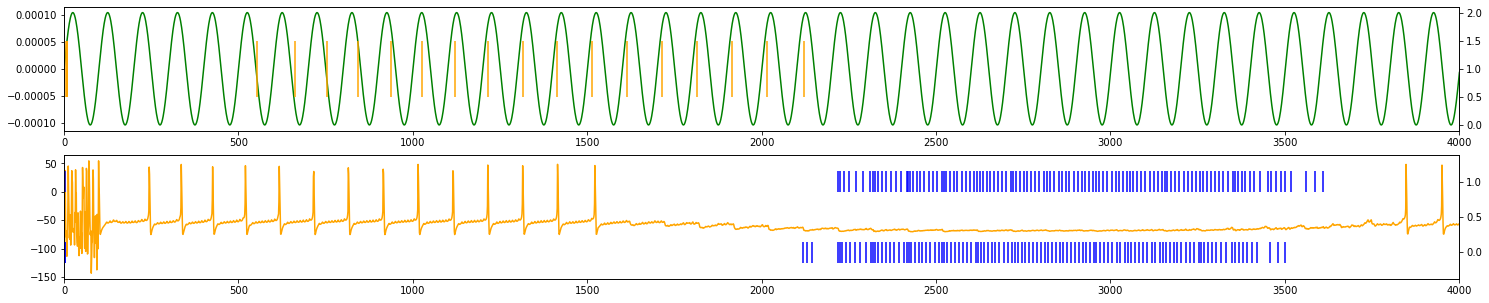

In [100]:
fig, ax = plt.subplots(2,1,figsize=(25,5))
ax[0].plot(i_theta.mean(0), color='green', label='Mean Theta Current')
ax[1].plot(stellate_v[0], color='orange', label='Mean Theta Current')
ax2 = ax[1].twinx()
ax1 = ax[0].twinx()
cells_to_plot = [i for i in range(-5,6,1)]
ax2.eventplot([intrnrn_spikes_l[32],intrnrn_spikes_l[-32]], lineoffsets=1, linelengths=0.3, colors='blue')

ax1.eventplot(stell_spikes_l[10], lineoffsets=1, linelengths=1, colors='orange')
#ax[1].eventplot(stell_spikes_l[0], lineoffsets=1, colors='blue', label='Stellate Cell Spikes')

ax[1].set_xlim(0,4000)
ax[0].set_xlim(0,4000) 
#ax[2].set_xlim(4000,6000)
ax[1].set_ylim()
#plt.legend()
plt.show() 

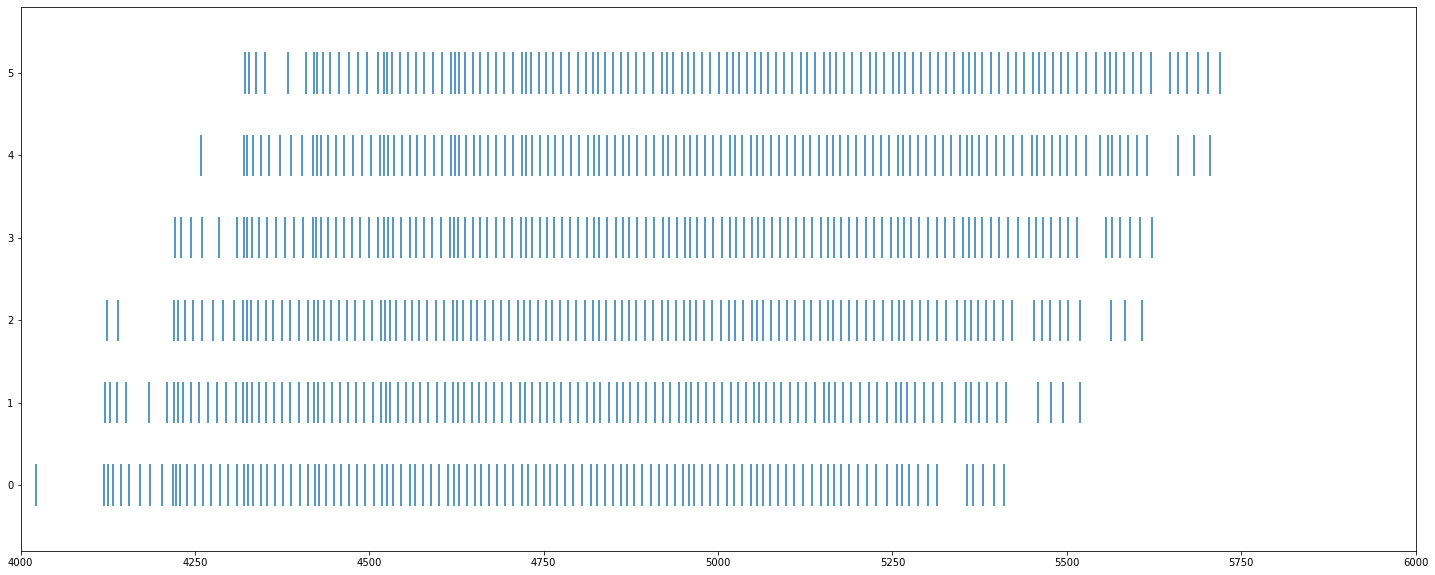

In [46]:
plt.figure(figsize=(25,10))
plt.eventplot(intrnrn_spikes_l[:6],linelengths=0.5)
plt.xlim(4000,6000)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[[0.75, 2.35, 27.825, 27.975, 28.175, 28.375, 28.75, 351.675, 453.65, 549.0, 642.4, 731.625, 823.2, 918.9, 1016.175, 1115.4, 1214.575, 1314.1, 1413.875, 1514.675, 1615.025, 1715.45, 1818.525, 1922.3], [4149.125, 4252.4, 4350.175, 4444.725, 4539.45, 4629.675, 4722.1, 4819.725, 4918.05, 5016.675, 5117.175, 5216.8, 5316.875, 5416.9, 5516.9, 5617.775, 5720.85, 5922.15], [8047.475, 8150.5, 8250.9, 8347.725, 8436.175, 8527.35, 8622.15, 8720.0, 8819.075, 8919.125, 9019.05, 9118.875, 9219.475, 9319.625, 9419.475, 9520.075, 9624.875], [12150.275, 12253.925, 12353.775, 12448.975, 12541.15, 12632.275, 12726.275, 12823.075, 12921.3, 13020.15, 13121.075, 13220.6, 13320.3, 13420.7, 13521.325, 13622.525, 13724.575], [16255.55, 16361.275, 16457.525, 16551.324, 16640.05, 16730.975, 16826.525, 16924.775, 17023.625, 17123.926, 17223.824, 17323.775, 17423.95, 17523.676], [20161.475, 20266.625, 20360.975, 20456.9, 20549.074, 20640.676, 20732.375, 20828.4, 20926.074, 21024.65, 21125.025, 21224.0, 21324.525,

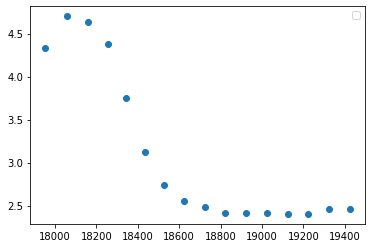

In [89]:

analytic_signal = signal.hilbert(-i_theta.mean(0)) # GET THE ANALYTICAL FORM OF THE THETA CURRENT SIGNAL
instantaneous_phase =np.angle(analytic_signal) #FIND INSTANTANEOUS PHASE OF THE THETA CURRENT
separated_fields=a_utils.separate_fields(stell_spikes_l[:params['N_per_sheet']])
field = np.array(separated_fields[100][5])
print(separated_fields[70])
field_idx = (field).astype('int')
phases=instantaneous_phase[field_idx]
phases_intrnrn = instantaneous_phase[np.array(intrnrn_spikes_l[-1],dtype="int")]

avg_v = np.vstack((stellate_v[:params['N_per_sheet']],intrnrn_v))
avg_v = np.mean(avg_v,axis=0)
filetered_avg=hf_p.filter_signal(avg_v,4,12,fs=1/0.001,order=4)
analytic_signal = signal.hilbert(filetered_avg)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase_lfp =np.angle(analytic_signal)
phases_lfp=instantaneous_phase_lfp[field_idx]

plt.figure()
plt.scatter(field,vectorized_convert_angle(phases))

plt.legend()
plt.show()

In [92]:

stell_spks,stell_phases=calc_phase_stell(stell_spikes_l[:params["N_per_sheet"]],params)
stell_spks_sep,stell_phases_sep=calc_phase_stell_field_sep(stell_spikes_l[:params["N_per_sheet"]],0)


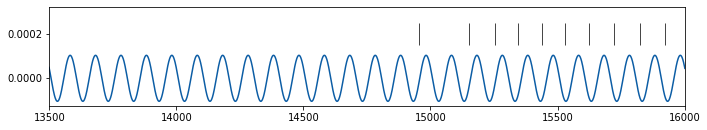

In [93]:
%matplotlib inline

fig,ax=plt.subplots(figsize=(2.277*5,0.363*5))

plt.eventplot(stell_spikes_l[179],linelengths=0.0001,lineoffsets=np.mean(i_theta.mean(0))+0.0002,linewidths=1,color="#474747")

plt.plot(-i_theta.mean(0),c="#0C5DA5")
plt.xlim([13500,16000])

plt.show()

[Text(0.5, 0, ''), Text(0, 0.5, '')]

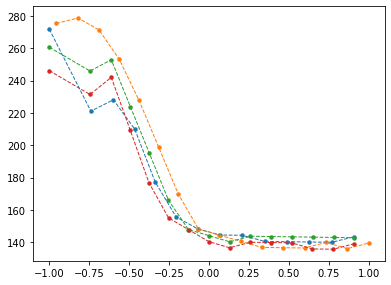

In [94]:
%matplotlib inline
fig,axs = plt.subplots(1,1,figsize=(1.259*5,0.936*5))
cells_to_plot=[179,141,190]
x=np.linspace(-1,1,100)
cmaps=plt.colormaps()
colors = [cm.Spectral(0.07),cm.Spectral(0.2),cm.Spectral(0.75),cm.Spectral(0.95)]

for i,field in enumerate(stell_spks_sep[cells_to_plot[0]][1:5]):
    k=i+1

    sns.scatterplot(x=field/np.max(abs(field)),
                    y=np.array(stell_phases_sep[cells_to_plot[0]][:][k])*180/np.pi,
                    ax=axs,
                    legend=False,s=20,linewidth=0)
    sns.lineplot(x=field/np.max(abs(field)),
                 y=np.array(stell_phases_sep[cells_to_plot[0]][:][k])*180/np.pi,
                 ax=axs,legend=False,
                 linewidth=1,linestyle="--",label=f"Field {k}")


axs.set(xlabel="",ylabel="")



[Text(0.5, 0, ''), Text(0, 0.5, '')]

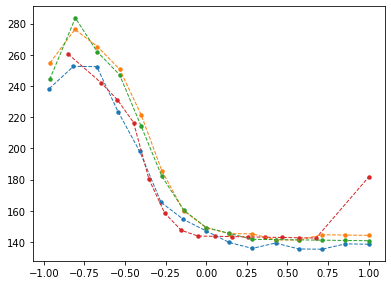

In [96]:
%matplotlib inline

fig,axs = plt.subplots(1,1,figsize=(1.259*5,0.936*5))
cells_to_plot=[179,141,190]
x=np.linspace(-1,1,100)
cmaps=plt.colormaps()
diff_cells_spks=[stell_spks_sep[23][4],stell_spks_sep[70][5],stell_spks_sep[100][6],stell_spks_sep[180][3]]
diff_cells_phases=[stell_phases_sep[23][4],stell_phases_sep[70][5],stell_phases_sep[100][6],stell_phases_sep[180][3]]
colors = [cm.Spectral(0.07),cm.Spectral(0.2),cm.Spectral(0.75),cm.Spectral(0.95)]
cells = [23,70,100,180]
cells=[0]
for i,field in enumerate(diff_cells_spks):

    sns.scatterplot(x=field/np.max(abs(field)),
                    y=np.array(diff_cells_phases[i])*180/np.pi,
                    ax=axs,
                    legend=True,s=20,linewidth=0)
    sns.lineplot(x=field/np.max(abs(field)),
                 y=np.array(diff_cells_phases[i])*180/np.pi,
                 ax=axs,
                    legend=False,linewidth=1,linestyle="--")

axs.set(xlabel="",ylabel="")



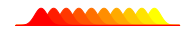

In [185]:
from network_configs.connections.conn_utils import gaussian

means = np.arange(10,110,10)
x=np.linspace(-10,120,1000)
color_idx = np.concatenate((np.linspace(0,0.3,5,endpoint=True),
                            np.linspace(0.7,1,5,endpoint=True)))
color_idx = np.linspace(0,1,10,endpoint=True)                          

colors_stell = cm.Spectral_r(color_idx)

colors_stell = cm.autumn_r(color_idx)



alpha = np.linspace(1,1,len(means))
gauss = np.zeros((len(means),len(x)))
for i in range(len(means)):
    gauss[i,:]=gaussian(x,1,means[i],5)
gauss= np.flip(gauss,axis=0)

fig,axs=plt.subplots(figsize=(3.227,0.348))

axs.spines["right"].set_visible(False)
axs.spines["top"].set_visible(False)
axs.spines["left"].set_visible(False)
axs.spines["bottom"].set_visible(False)
for i in range(len(means)):
    plt.fill_between(x,gauss[i],color=colors_stell[i],alpha=alpha[i])
plt.xticks([])
plt.yticks([])


plt.show()

/tmp/ipykernel_102555/1329406071.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(axs.get_xticks()/1000)
/tmp/ipykernel_102555/1329406071.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_yticklabels(np.round(axs.get_yticks()*1000,2))
/tmp/ipykernel_102555/1329406071.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels((axs.get_yticks()+cells_to_plot[0]).astype("int"))


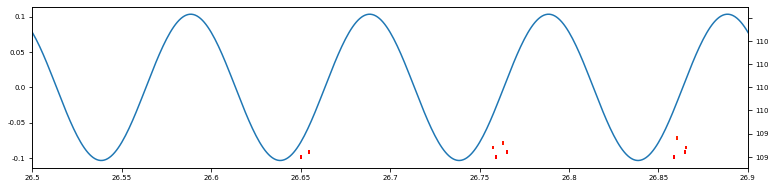

In [97]:

fig,axs=plt.subplots(figsize=(2.614*5-0.25,0.592*5))
cells_to_plot = np.arange(110,141)
color_idx = np.concatenate((np.linspace(0,0.3,len(cells_to_plot)//2,endpoint=True),
                            np.linspace(0.7,1,len(cells_to_plot)//2+1,endpoint=True)))
color_idx = np.linspace(0,1,len(cells_to_plot),endpoint=True)                          

colors = cm.autumn(color_idx)
ax2 = axs.twinx()
ax2.eventplot(stell_spikes_l[cells_to_plot[0]:cells_to_plot[-1]+1],colors=colors,linewidths=2,linelengths=0.8,zorder=100,alpha=1)
axs.plot(-i_theta.mean(0))
d=1500
s=25000
ax2.spines["right"].set_visible(True)
plt.xlim([s+d,s+400+d])

axs.set_xticklabels(axs.get_xticks()/1000)
axs.set_yticklabels(np.round(axs.get_yticks()*1000,2))




ax2.set_yticklabels((axs.get_yticks()+cells_to_plot[0]).astype("int"))

axs.tick_params(axis='both', which='major', labelsize=7)
ax2.tick_params(axis='both', which='major', labelsize=7)


plt.show()



AttributeError: 'NoneType' object has no attribute 'ax'

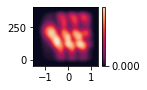

In [116]:


two_d_hist_plot = {"field_loc":[],"phase":[]}
for i in range(len(stell_spks)):
    two_d_hist_plot["field_loc"].extend(list(np.array(stell_spks[i])/np.max(stell_spks[i])))
    two_d_hist_plot["phase"].extend(np.array(stell_phases[i])*180/np.pi)

plt.rcParams['xtick.direction'] = "out"
plt.rcParams['ytick.direction'] = "out"
f, ax = plt.subplots(1,1,figsize=(2.021-0.575, 1.465-0.383))

sns.kdeplot(data=two_d_hist_plot,x="field_loc",y="phase",cmap="rocket",thresh=None,fill=True,cbar=True,ax=ax,levels=100,cbar_kws={"format":"%.3f","ticks":[0.000,0.004,0.009,0.018]})


ax.set_xlabel("")
ax.set_ylabel("")
ax.grid(False) 
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)
ax.tick_params(axis='both', which='major', labelsize=7)



plt.show()




AttributeError: 'NoneType' object has no attribute 'ax'

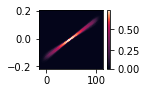

In [117]:


N_per_sheet= params['N_per_sheet']
n_phases= 64 
sim_dur= params['sim_dur']
cell_phases = (np.arange(0,N_per_sheet)*(2*np.pi/n_phases))%(2*np.pi)
t_stell=a_utils.instant_rate_all(stell_spikes_l[:params['N_per_sheet']],sim_dur,50)


decoded_pos=vectorized_convert_angle(((np.angle(np.sum((t_stell*np.exp(1j*cell_phases[:,np.newaxis])),axis=0)))))


theta_max_idx=signal.argrelmax(-i_theta.mean(0))[0]

theta_max_idx=np.sort(np.concatenate((theta_max_idx[10:],theta_max_idx[9:-1])))

theta_max_idx=np.reshape(theta_max_idx,(len(theta_max_idx)//2,2))

positions=[]
for win in range(len(theta_max_idx)):
    pos=decoded_pos[theta_max_idx[win,0]:theta_max_idx[win,1]]

    pos = (pos-stats.circmean(pos))%(2*np.pi)
    pos[pos>np.pi]= pos[pos>np.pi]-(2*np.pi)

    positions.append(list(pos)[:100])
%matplotlib inline
pos=np.array(positions).ravel()
x = np.tile(np.arange(100),len(positions))

plt.rcParams['xtick.direction'] = "out"
plt.rcParams['ytick.direction'] = "out"
fig,ax=plt.subplots(figsize=(2.021-0.575, 1.465-0.383))
sns.kdeplot(x=x,y=pos,cmap="rocket",thresh=None,fill=True,cbar=True,levels=100,cbar_kws={"format":"%.2f","ticks":[0,0.25,0.5]},ax=ax)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)
ax.tick_params(axis='both', which='major', labelsize=7)

ax.set_ylim([-0.15,0.15])



In [186]:

all_scores = np.full(len(stell_spks),0,dtype='float')
all_slopes = np.full(len(stell_spks),0,dtype='float')
all_corr_coeff = np.full(len(stell_spks),0,dtype='float')
for j,i in enumerate(stell_spks.keys()):
    if len(stell_spks[i])<1 or len(stell_phases[i])<1:
        continue

    slopes=np.linspace(-5,5,1000)
    scores = np.zeros(10000)
    for k,val in enumerate(slopes):
        scores[k]=hf_p.circ_regr(val,np.array(stell_spks[i])/np.max(stell_spks[i]),np.array(stell_phases[i]))
    qhat=slopes[np.argmax(scores)]
    offset=np.arctan2(np.sum(np.sin(np.array(stell_phases[i])-2*np.pi*qhat*np.array(stell_spks[i])/np.max(stell_spks[i]))),np.sum(np.cos(np.array(stell_phases[i])-2*np.pi*qhat*np.array(stell_spks[i])/np.max(stell_spks[i]))))
    stell_spks_norm =stell_spks[i]/np.max(stell_spks[i])
    phi_bar = np.arctan2(np.sum(np.sin(stell_phases[i])),np.sum(np.cos(stell_phases[i])))
    theta_j = (2*np.pi*abs(qhat)*stell_spks_norm)%(2*np.pi)
    theta_bar = np.arctan2(np.sum(np.sin(theta_j)),np.sum(np.cos(theta_j)))
    denom =np.sqrt(np.sum(np.sin(stell_phases[i]-phi_bar)**2)*np.sum(np.sin(theta_j-theta_bar)**2))
    corr_coef=np.sum(np.sin(stell_phases[i]-phi_bar)*np.sin(theta_j-theta_bar))/denom
    all_scores[j]=np.max(scores)
    all_slopes[j]=qhat
    all_corr_coeff[j]=corr_coef


In [187]:

all_scores = np.full(len(stell_spks),0,dtype='float')
all_slopes = np.full(len(stell_spks),0,dtype='float')
all_corr_coeff = np.full(len(stell_spks),0,dtype='float')
slopes=[]

for j,i in enumerate(stell_spks.keys()):
    if len(stell_spks[i])<1 or len(stell_phases[i])<1:
        continue
    stell_spks_cm=(np.array(stell_spks[i])-np.min(stell_spks[i]))
    slopes.append(stats.linregress(stell_spks_cm,stell_phases[i]).slope)


In [188]:
from joblib import Parallel, delayed, parallel_config

def calculate_phase_range():
    data=np.zeros((len(stell_spks),4))

    print("Starting analysis")
    def my_func(i):
        corr_coef,slope,score,offset=hf_p.regression(stell_spks[i],stell_phases[i])
        return slope,offset,corr_coef,score

    with parallel_config(backend='threading'):
        data[:,:]=Parallel(n_jobs=int(40))(delayed(my_func)(i) for i in stell_spks.keys())
    print("Analysis Complete")
    return data
data=calculate_phase_range()
slope_deg = data[:,0]*2*np.pi*(180/np.pi)


Starting analysis
Analysis Complete


In [189]:
stats.circmean(1*data[:,0]*2*np.pi+data[:,1]-(-1*data[:,0]*2*np.pi+data[:,1]),low=-2*np.pi,high=2*np.pi)

-2.9662556920881458

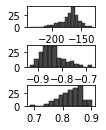

In [190]:
all_slopes_deg=slope_deg*2
all_corr_coeff=data[:,2]
all_scores=data[:,3]
x = np.arange(0,101)
f, ax = plt.subplots(3,1,figsize=(1.223, 1.832))
sns.histplot((all_slopes_deg),ax=ax[0],color="#474747",alpha=1)
sns.histplot((all_corr_coeff),ax=ax[1],color="#474747",alpha=1)
ax[0].set(ylabel='')
sns.histplot(all_scores,ax=ax[2],color="#474747",alpha=1)
ax[1].set(ylabel='')

ax[2].set(ylabel='')
plt.subplots_adjust(hspace=0.85)



In [20]:
se = np.std(all_slopes_deg)/np.sqrt(len(all_slopes_deg))
se

1.4276475278386433